<a href="https://colab.research.google.com/github/siddas18/Natural-Disaster-Damage-Prediction/blob/Kartik/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

  Cloning git://github.com/geopandas/geopandas.git to /private/var/folders/cs/gfkz548n05j35ht629xxvggh0000gn/T/pip-req-build-1igj1i8f
  Running command git clone -q git://github.com/geopandas/geopandas.git /private/var/folders/cs/gfkz548n05j35ht629xxvggh0000gn/T/pip-req-build-1igj1i8f
CPU times: user 953 ms, sys: 401 ms, total: 1.35 s
Wall time: 34.3 s


In [2]:
## Generic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from math import sqrt, isnan
import requests
import gzip
from functools import reduce
import scipy as scp
import seaborn as sns
import scipy.interpolate
#


## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## Metrics
from sklearn.metrics import mean_squared_error, r2_score, f1_score


import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

In [3]:
import geopandas as gpd

In [4]:
def get_NOAA_data():
    
    URL = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
    r = requests.get(URL)
    file_names = pd.read_html(r.text)[0]['Name']
    events_file_names = file_names[file_names.str.contains("details",na=False)]
    noaa_list = []
    
    print("Extracting CSV files...")
    for file in events_file_names:
        full_URL = URL + file
        with gzip.open(requests.get(full_URL, stream=True).raw) as f:
            noaa_list.append(pd.read_csv(f))
        
    df = pd.concat(noaa_list)
    
    print("Completed")
    return df

def pickle_source_data():
    noaa_source_df = get_NOAA_data()
    home_dir = os.getcwd()
    data_dir = os.path.join(home_dir, "Data")
    try:
        os.mkdir(data_dir)
        os.chdir(data_dir)
    except OSError:
        os.chdir(data_dir)
        for file in os.listdir():
            os.remove(file)
    noaa_source_df.to_pickle('noaa_source_data.pkl')
    os.chdir(home_dir)
    return noaa_source_df

NOAA_df = pickle_source_data()
    

Extracting CSV files...
Completed


In [5]:
 pickle_df = pd.read_pickle('Data/noaa_source_data.pkl')

In [6]:
NOAA_df = pd.read_pickle('Data/noaa_source_data.pkl')

In [7]:
def replace_str2num(x):
    if type(x) == float or type(x) == int:
        return float(x)
    num = 1 if x[:-1] == '' else x[:-1]        
    if x[-1] == 'T':
        return float(num) * 1000000000000
    elif x[-1] == 'B':
        return float(num) * 1000000000
    elif x[-1] == 'M':
        return float(num) * 1000000
    elif x[-1] == 'K' or x[-1] == 'k':
        return float(num) * 1000
    elif x[-1] == 'h' or x[-1] == 'H':
        return float(num) * 100
    elif x[-1] == '?':
        return float(num)
    else:
        return float(x)

def winds(x):
    if x['MAGNITUDE_TYPE'] in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def hail(x):
    if x['MAGNITUDE_TYPE'] not in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def missing_swap(df, col1, col2):
    df.loc[~df[col1].isnull() & df[col2].isnull(), col2] = df.loc[~df[col1].isnull() & df[col2].isnull(), col1]
    df.loc[df[col1].isnull() & ~df[col2].isnull(), col1] = df.loc[df[col1].isnull() & ~df[col2].isnull(), col2]
    return df

<AxesSubplot:xlabel='YEAR'>

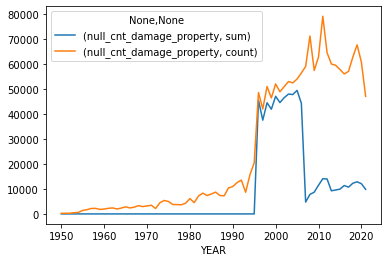

In [8]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_CROPS'].isnull()
df1 = NOAA_df.groupby('YEAR').agg({'null_cnt_damage_property' : ['sum', 'count']})
df1.plot()

In [9]:
print(NOAA_df)
print(os.getcwd())

       BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  \
0               195004         28        1445         195004       28   
1               195004         29        1530         195004       29   
2               195007          5        1800         195007        5   
3               195007          5        1830         195007        5   
4               195007         24        1440         195007       24   
...                ...        ...         ...            ...      ...   
47044           202106         13        1430         202106       13   
47045           202106         13        1430         202106       13   
47046           202106         13        1530         202106       13   
47047           202106         12        2230         202106       12   
47048           202106         13          29         202106       13   

       END_TIME  EPISODE_ID  EVENT_ID         STATE  STATE_FIPS  ...  \
0          1445         NaN  10096222      OKLAHOMA

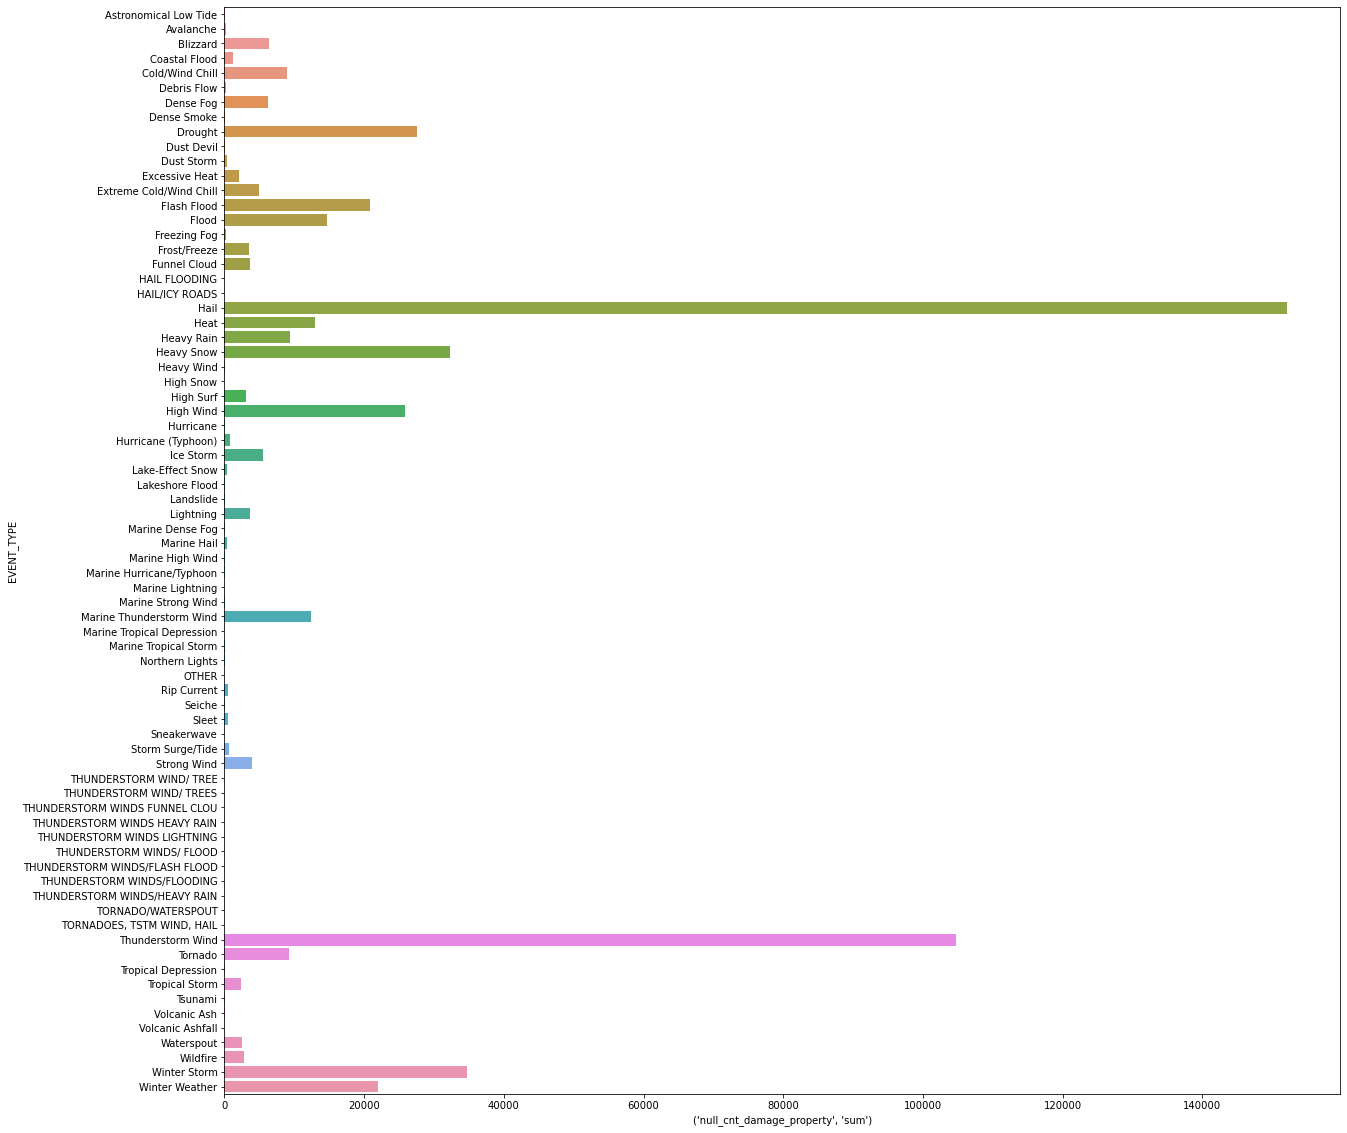

In [10]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_PROPERTY'].isnull()
df1 = NOAA_df.groupby('EVENT_TYPE').agg({'null_cnt_damage_property' : ['sum', 'count']}).reset_index()
df1['perc'] = df1[('null_cnt_damage_property', 'sum')] / df1[('null_cnt_damage_property', 'count')] * 100
plt.figure(figsize=(20, 20))
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df1, y='EVENT_TYPE', x=('null_cnt_damage_property', 'sum'))

plt.show()

In [11]:
NOAA_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,null_cnt_damage_property
0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,40.0,...,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,False
1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,48.0,...,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,False
2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,42.0,...,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,False
3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,42.0,...,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,False
4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,42.0,...,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,False


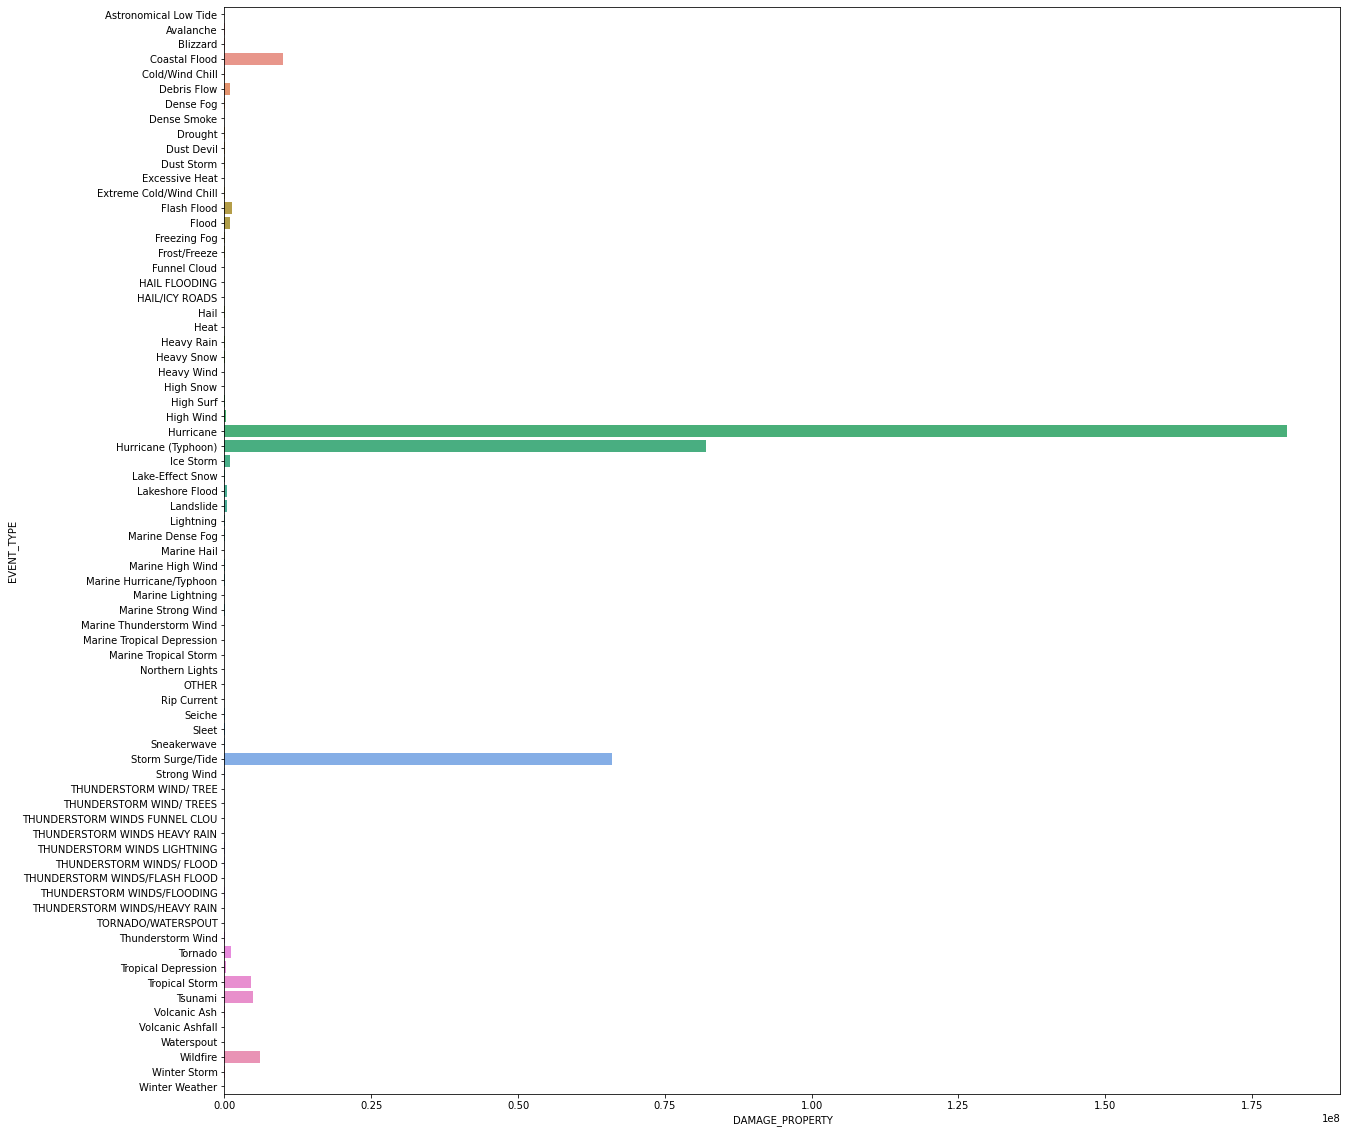

In [12]:
NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)
NOAA_df['DAMAGE_CROPS'] = NOAA_df.DAMAGE_CROPS.map(replace_str2num)
df2 = NOAA_df.groupby('EVENT_TYPE').mean()['DAMAGE_PROPERTY'].reset_index()
df2 = df2[df2.EVENT_TYPE != 'TORNADOES, TSTM WIND, HAIL']
plt.figure(figsize=(20, 20))
# df2.head()
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df2, y='EVENT_TYPE', x='DAMAGE_PROPERTY')
plt.show()
# NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)

In [76]:
NOAA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1237989 entries, 0 to 47048
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   BEGIN_YEARMONTH           1237989 non-null  int64  
 1   BEGIN_DAY                 1237989 non-null  int64  
 2   BEGIN_TIME                1237989 non-null  int64  
 3   END_YEARMONTH             1237989 non-null  int64  
 4   END_DAY                   1237989 non-null  int64  
 5   END_TIME                  1237989 non-null  int64  
 6   EPISODE_ID                1237989 non-null  float64
 7   EVENT_ID                  1237989 non-null  int64  
 8   STATE                     1237988 non-null  object 
 9   STATE_FIPS                1237988 non-null  float64
 10  YEAR                      1237989 non-null  int64  
 11  MONTH_NAME                1237989 non-null  object 
 12  EVENT_TYPE                1237989 non-null  object 
 13  CZ_TYPE                   123

In [14]:
print(NOAA_df.shape[0])

NOAA_df = NOAA_df[NOAA_df['YEAR']> 2000]

print(NOAA_df.shape[0])
print(NOAA_df['STATE'].isna().sum())

for i in NOAA_df.columns:
    if NOAA_df[i].isna().sum() > 0:
        print(NOAA_df[i].name, ":", NOAA_df[i].isna().sum(), "\n")
        print((NOAA_df[i].isna().sum()/NOAA_df.shape[0])*100, "\n")
    else:
        continue

1710146
1237989
1
STATE : 1 

8.077616198528421e-05 

STATE_FIPS : 1 

8.077616198528421e-05 

DAMAGE_PROPERTY : 374456 

30.24711851236158 

DAMAGE_CROPS : 439088 

35.46784341379447 

MAGNITUDE : 574102 

46.37375614807563 

MAGNITUDE_TYPE : 821720 

66.37538782654772 

FLOOD_CAUSE : 1140697 

92.14112564812773 

CATEGORY : 1237545 

99.96413538407853 

TOR_F_SCALE : 1209093 

97.66589202327323 

TOR_LENGTH : 1209093 

97.66589202327323 

TOR_WIDTH : 1209093 

97.66589202327323 

TOR_OTHER_WFO : 1235431 

99.79337457764164 

TOR_OTHER_CZ_STATE : 1235431 

99.79337457764164 

TOR_OTHER_CZ_FIPS : 1235431 

99.79337457764164 

TOR_OTHER_CZ_NAME : 1235431 

99.79337457764164 

BEGIN_RANGE : 571983 

46.20259146082881 

BEGIN_AZIMUTH : 571983 

46.20259146082881 

BEGIN_LOCATION : 448507 

36.22867408353386 

END_RANGE : 571975 

46.201945251532926 

END_AZIMUTH : 571975 

46.201945251532926 

END_LOCATION : 448493 

36.22754321726607 

BEGIN_LAT : 482521 

38.97619445730132 

BEGIN_LON :

In [15]:
def impute_NOAA_data(df):
    
    # maginitude converted into other variables
    drop_list = ['EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'EPISODE_ID', 'MAGNITUDE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO','TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME']
    impute_mean_list = ['BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON']
    
    # imputing damage columns with 0 for the time-being
    impute_zero_list = ['BEGIN_RANGE', 'END_RANGE', 'DAMAGE_CROPS', 'DAMAGE_PROPERTY', 'WIND_SPEED', 'HAIL_SIZE']
    impute_NA_list = ['SOURCE', 'WFO', 'CZ_NAME', 'DATA_SOURCE', 'STATE','STATE_FIPS', 'MAGNITUDE_TYPE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', 'END_LOCATION']
    
    # Removing inconsistencies
    df = missing_swap(df, 'BEGIN_RANGE', 'END_RANGE')
    df = missing_swap(df, 'BEGIN_LAT', 'END_LAT')
    df = missing_swap(df, 'BEGIN_LON', 'END_LON')
    df = missing_swap(df, 'BEGIN_AZIMUTH', 'END_AZIMUTH')
    df = missing_swap(df, 'BEGIN_LOCATION', 'END_LOCATION')
    
    # Damage variables cleaning
    df['DAMAGE_PROPERTY'] = df.DAMAGE_PROPERTY.map(replace_str2num)
    df['DAMAGE_CROPS'] = df.DAMAGE_CROPS.map(replace_str2num)
    
    # Splitting magnitude variable into constituent attributes
    df['WIND_SPEED'] = df.apply(winds, axis = 1)
    df['HAIL_SIZE'] = df.apply(hail, axis = 1)
    
    # Imputing string columns with missing values with N/A
    for col in impute_NA_list:
        df[col] = df[col].astype('str').apply(lambda x: 'N/A' if x=='nan' else x)
        
    # Imputing float columns having missing values with 0.0
    for col in impute_zero_list:
        df[col] = df[col].fillna(0.0)
        
    # Imputing latitude and longitudes with average value
    for col in impute_mean_list:
        df[col] = df[col].fillna(np.mean)
        
    # Dropping text and ID columns
    for col in drop_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

# NOAA_df.dropna(subset=["DAMAGE_PROPERTY"], inplace=True)
# NOAA_df.dropna(subset=["DAMAGE_CROPS"], inplace=True)

imputed_NOAA_df = impute_NOAA_data(NOAA_df.copy())
imputed_NOAA_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EVENT_ID,STATE,STATE_FIPS,YEAR,...,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,null_cnt_damage_property,WIND_SPEED,HAIL_SIZE
0,200111,28,600,200111,29,1800,5274875,TEXAS,48.0,2001,...,N/A,N/A,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,PDS,True,0.0,0.0
1,200110,24,1925,200110,24,1925,5274950,LAKE ERIE,95.0,2001,...,N/A,STONY POINT,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,PDS,True,45.0,0.0
2,200112,1,900,200112,1,1800,5275049,NEW JERSEY,34.0,2001,...,N/A,N/A,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,PDS,False,0.0,0.0
3,200111,29,600,200111,29,1800,5274877,TEXAS,48.0,2001,...,N/A,N/A,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,PDS,True,0.0,0.0
4,200111,15,800,200111,30,800,5274892,SOUTH CAROLINA,45.0,2001,...,N/A,N/A,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,<function mean at 0x7f8d5c2a4d30>,PDS,True,0.0,0.0


In [16]:
def get_EPA_data():
    
    ground_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/temperature_fig-1.csv', skiprows=6, usecols = [0, 1], encoding='latin1')
    ground_temp_df.columns = ["YEAR", "SURFACE_TEMP_DIFF"]
    
    greenhouse_df = pd.read_csv("https://www.epa.gov/sites/default/files/2021-04/us-ghg-emissions_fig-1.csv",skiprows=6)
    greenhouse_df.columns = ["YEAR", "CO2", "METHANE", "N2O", "HFC_PFC_SF6_NF3"]
    
    precipitation_df =  pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/heavy-precip_fig-1.csv',skiprows=6)
    precipitation_df.columns = ["YEAR", "PPT_LAND_AREA", "PPT_NINE_YEAR_AVG"]
    
    sea_level_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/sea-level_fig-1.csv', skiprows=6)
    sea_level_df.columns = ["YEAR", "CSIRO_ADJ_SEA_LEVEL", "CSIRO_LOWER", "CSIRO_UPPER", "NOAA_ADJ_SEA_LEVEL"]
    sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'CSIRO_ADJ_SEA_LEVEL'] = sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'NOAA_ADJ_SEA_LEVEL']
    sea_level_df.drop(['CSIRO_LOWER', 'CSIRO_UPPER', 'NOAA_ADJ_SEA_LEVEL'], axis=1, inplace=True)
    
    seasonal_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/seasonal-temperature_fig-1.csv', skiprows=6)
    seasonal_temp_df.columns = ["YEAR", "WINTER_ANOMALY", "SPRING_ANOMALY", "SUMMER_ANOMALY", "FALL_ANOMALY"]
    
    arctic_ice_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/arctic-sea-ice_fig-1.csv', skiprows=6)
    arctic_ice_df.columns = ["YEAR", "ICE_CVG_MARCH", "ICE_CVG_SEP"]
    
    glacier_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/glaciers_fig-1.csv', skiprows=6)
    glacier_df.columns = ["YEAR", "GLACIER_MASS_BAL", "NUM_OBS"]
    glacier_df.drop(['NUM_OBS'], axis=1, inplace=True)
    
    dfs = [ground_temp_df, greenhouse_df, precipitation_df, sea_level_df, seasonal_temp_df, arctic_ice_df, glacier_df]
    epa_df = reduce(lambda left, right: pd.merge(left, right, how="outer", on="YEAR"), dfs)
    epa_df = epa_df[epa_df.YEAR >= 1950]
    
    return epa_df

epa_source_df = get_EPA_data()

In [17]:
def impute_EPA_DATA(df, breaks):
    fillable_cols = df.columns[df.isnull().sum() > 0]
    for col in fillable_cols:
        temp_df = df[['YEAR', col]]
        present_df = temp_df[~ temp_df[col].isnull()]
        null_df = temp_df[temp_df[col].isnull()]
        years = sorted(np.random.choice(present_df['YEAR'], breaks))
        input_df = present_df[present_df['YEAR'].isin(years)]
        func = scipy.interpolate.interp1d(input_df['YEAR'], input_df[col], fill_value="extrapolate")
        temp_df['INTERPOLATION'] = func(temp_df['YEAR'])
        df[col] = temp_df.apply(lambda x: x['INTERPOLATION'] if isnan(x[col]) else x[col], axis=1)
    return df
        
imputed_EPA_df = impute_EPA_DATA(epa_source_df.copy(), 6)
imputed_EPA_df.head()

,YEAR,SURFACE_TEMP_DIFF,CO2,METHANE,N2O,HFC_PFC_SF6_NF3,PPT_LAND_AREA,PPT_NINE_YEAR_AVG,CSIRO_ADJ_SEA_LEVEL,WINTER_ANOMALY,SPRING_ANOMALY,SUMMER_ANOMALY,FALL_ANOMALY,ICE_CVG_MARCH,ICE_CVG_SEP,GLACIER_MASS_BAL
49,1950,-0.63,4032.931235,1054.109585,409.327040,307.735882,0.100,0.085488,3.598425,0.85,-1.94,-1.68,0.32,5.575315,4.095257,1.824636
50,1951,-0.90,4059.944321,1047.178663,410.410302,304.514723,0.107,0.093453,3.972441,0.35,-1.24,-0.66,-1.49,5.594620,4.052142,1.569045
51,1952,0.25,4086.957407,1040.247741,411.493564,301.293564,0.077,0.099285,3.870079,0.67,-0.94,1.16,-0.63,5.613925,4.009027,1.313455
52,1953,1.35,4113.970493,1033.316819,412.576826,298.072406,0.123,0.102855,4.043307,3.02,-0.36,0.75,1.87,5.633230,3.965913,1.057864
53,1954,1.31,4140.983579,1026.385896,413.660089,294.851247,0.099,0.101262,3.929134,3.10,-0.25,0.77,1.51,5.652536,3.922798,0.802273


In [18]:
# cleaned_df = pd.merge(imputed_NOAA_df, imputed_EPA_df, on='YEAR', how='inner')
cleaned_df = imputed_NOAA_df
cleaned_df.to_pickle('cleaned.pkl')

In [19]:
#from google.colab import drive
#drive.mount('/content/drive')

In [20]:
import pandas as pd

NOAA = pd.read_pickle('cleaned.pkl')

df_train = NOAA[NOAA['YEAR'] >= 2005]

In [21]:
df_train.to_csv(r'df_train1.csv')
df_train11 = gpd.read_file('df_train1.csv')

In [22]:
type(df_train11)

geopandas.geodataframe.GeoDataFrame

In [46]:
#df_train11.head(25)
df_train11.info()

df_train11["YEAR"] = df_train11["YEAR"].astype(int)
df_train11["DAMAGE_PROPERTY"] = df_train11["DAMAGE_PROPERTY"].astype(float)
df_train11["DAMAGE_CROPS"] = df_train11["DAMAGE_CROPS"].astype(float)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1032813 entries, 0 to 1032812
Data columns (total 43 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   field_1                   1032813 non-null  object  
 1   BEGIN_YEARMONTH           1032813 non-null  object  
 2   BEGIN_DAY                 1032813 non-null  object  
 3   BEGIN_TIME                1032813 non-null  object  
 4   END_YEARMONTH             1032813 non-null  object  
 5   END_DAY                   1032813 non-null  object  
 6   END_TIME                  1032813 non-null  object  
 7   EVENT_ID                  1032813 non-null  object  
 8   STATE                     1032813 non-null  object  
 9   STATE_FIPS                1032813 non-null  object  
 10  YEAR                      1032813 non-null  int64   
 11  MONTH_NAME                1032813 non-null  object  
 12  EVENT_TYPE                1032813 non-null  object  
 13  CZ_T

In [25]:
import geopandas as gpd
import geoplot as gplt

# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

ModuleNotFoundError: No module named 'geoplot'

<AxesSubplot:>

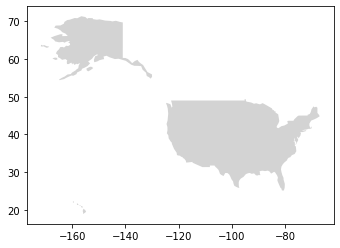

In [50]:
countries[countries["name"] == "United States of America"].plot(color="lightgrey")

In [51]:
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


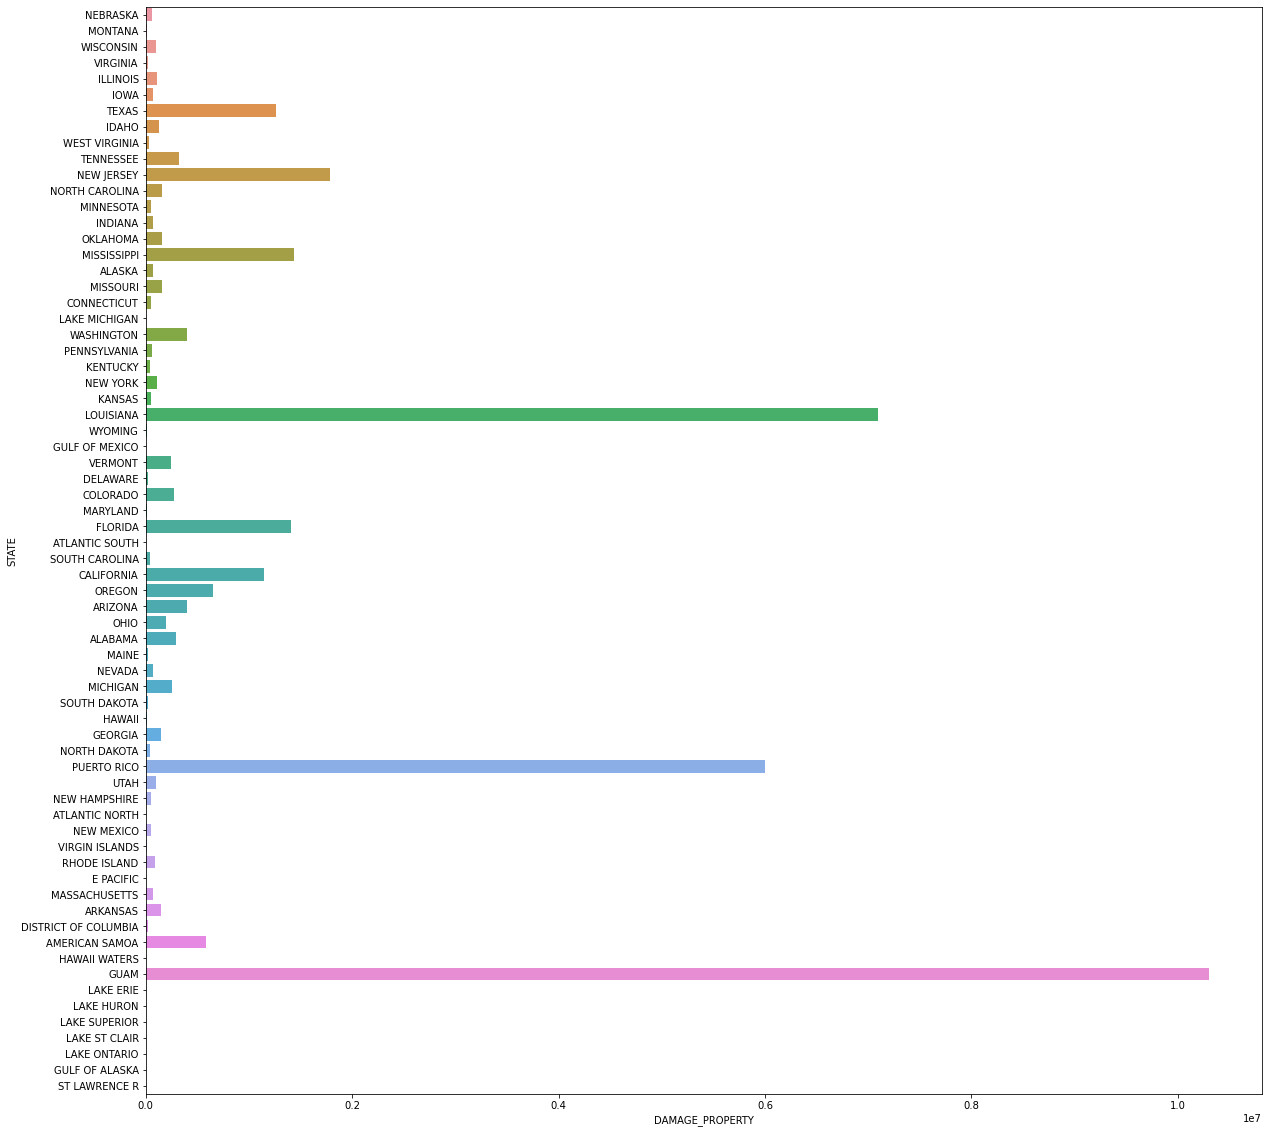

In [114]:
plt.figure(figsize=(20, 20))

sns.barplot(data=df_train11, y='STATE', x='DAMAGE_PROPERTY',ci=None)
plt.show()


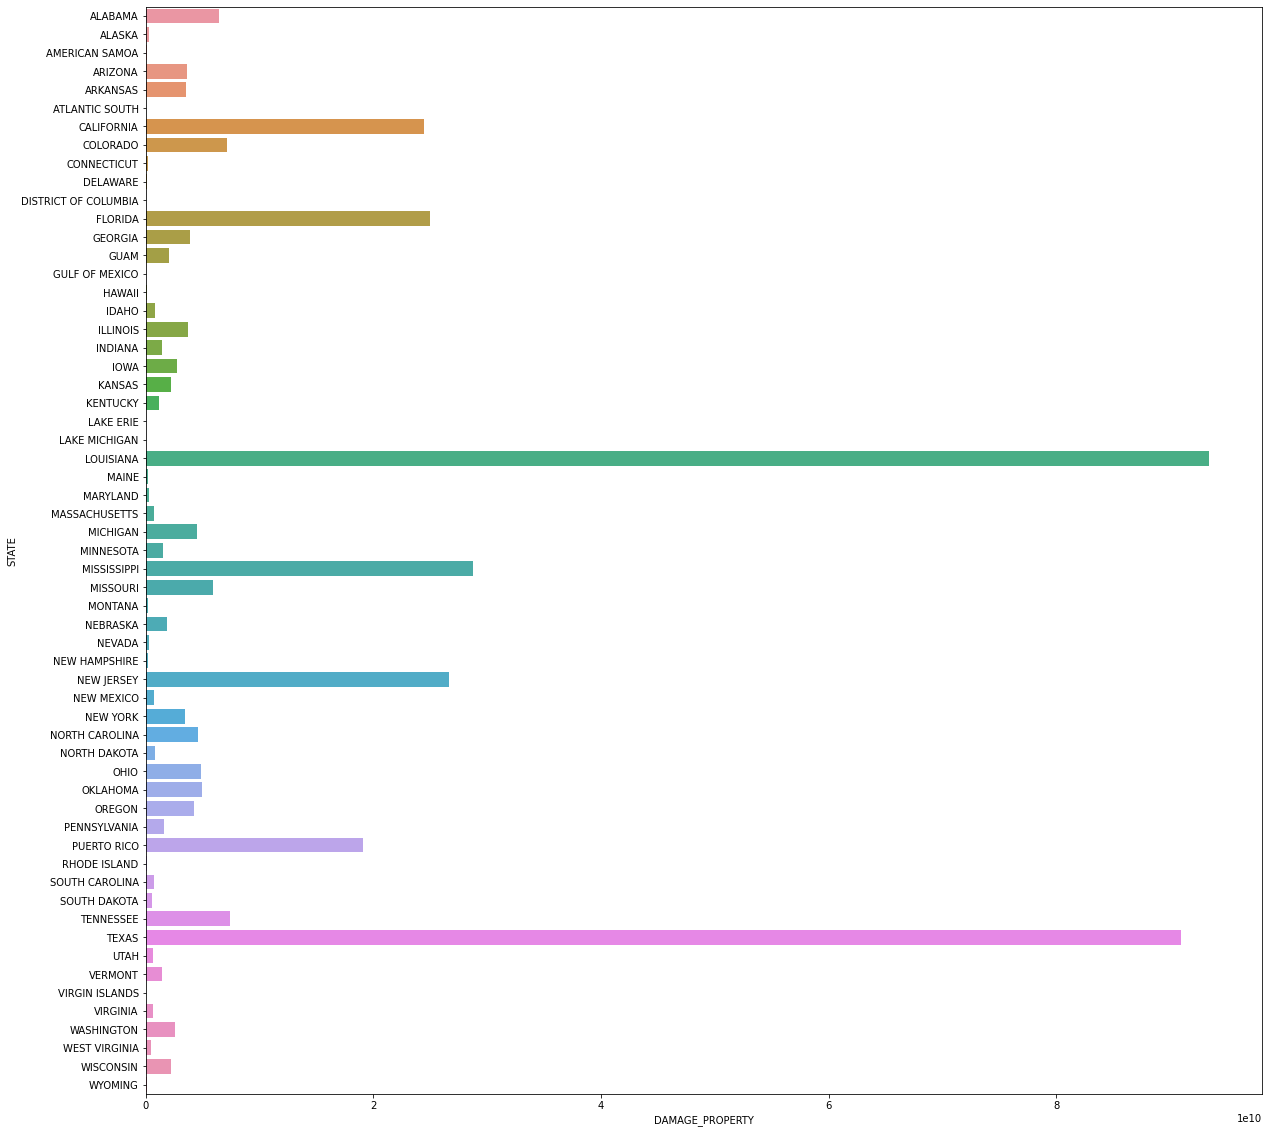

In [110]:
plt.figure(figsize=(20, 20))
df11 = df_train[['STATE','DAMAGE_PROPERTY']]
df111 = df11.groupby('STATE'.sum().reset_index()
df1111 = df111[df111.DAMAGE_PROPERTY > 1000000]
sns.barplot(data= df1111, y='STATE', x='DAMAGE_PROPERTY')
plt.show()

# # plt.figure(figsize=(20, 20))
# # sns.barplot(data=df_train11, y='STATE', x='DAMAGE_CROPS')
# # plt.show()

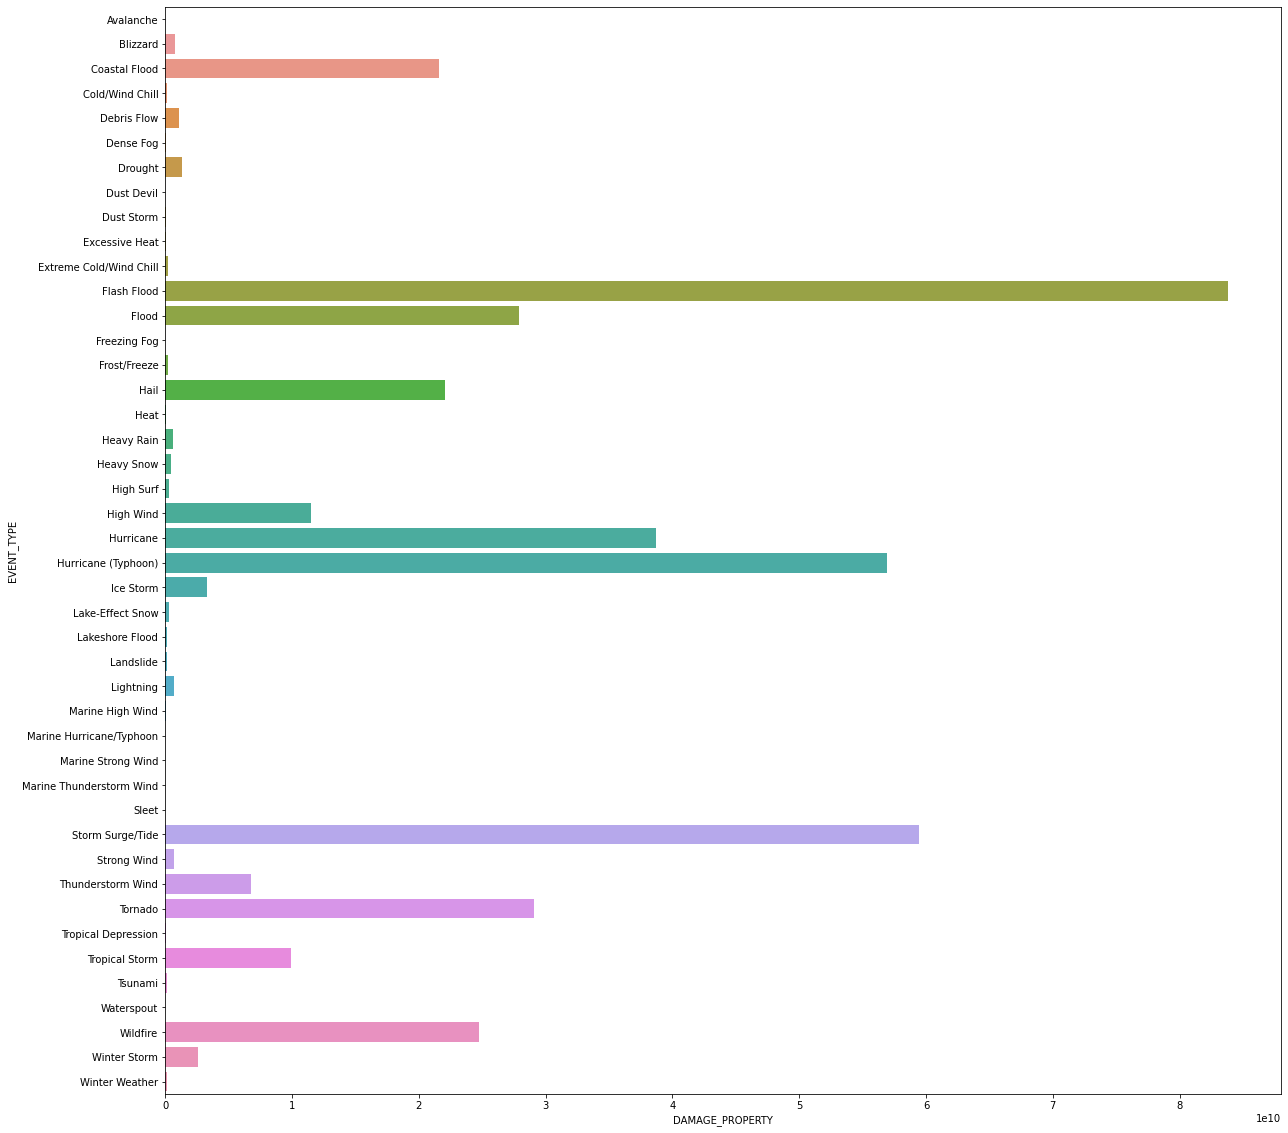

In [131]:
plt.figure(figsize=(20, 20))

# df11= df_train.groupby('STATE')

df12 = df_train[['EVENT_TYPE','DAMAGE_PROPERTY']]
df122 = df12.groupby('EVENT_TYPE').sum().reset_index()
df1222 = df122[df122.DAMAGE_PROPERTY > 1000000]
g = sns.barplot(data= df1222, y='EVENT_TYPE', x='DAMAGE_PROPERTY',ci=None)
plt.show()

In [122]:
df12

,EVENT_TYPE,DAMAGE_PROPERTY
0,Heavy Snow,0.0
1,Heavy Snow,0.0
2,Heavy Snow,0.0
3,Heavy Snow,0.0
4,Heavy Snow,0.0
...,...,...
70,High Wind,10000.0
71,Ice Storm,0.0
72,Ice Storm,0.0
73,Ice Storm,0.0


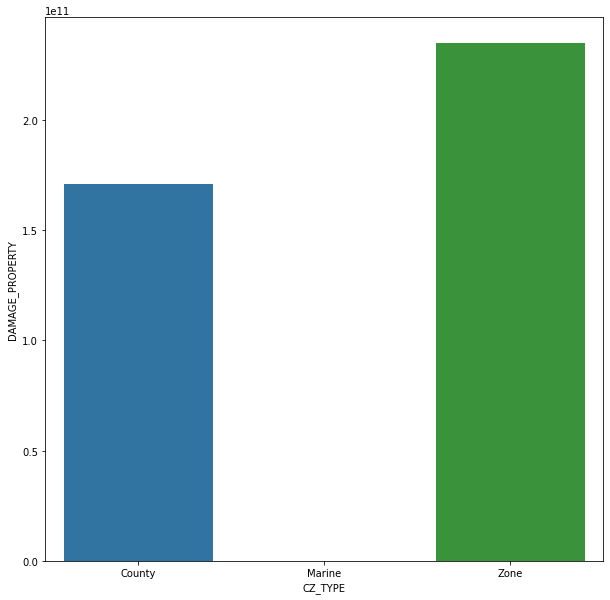

In [139]:
plt.figure(figsize=(10, 10))

# df11= df_train.groupby('STATE')

df13 = df_train[['CZ_TYPE','DAMAGE_PROPERTY']]
df13 = df13.replace({'C': 'County', 'M': 'Marine', 'Z': 'Zone'})
df133 = df13.groupby('CZ_TYPE').sum().reset_index()
df1333 = df133[df133.DAMAGE_PROPERTY > 1000000]
g = sns.barplot(data= df133, x='CZ_TYPE', y='DAMAGE_PROPERTY',ci=None)
plt.show()

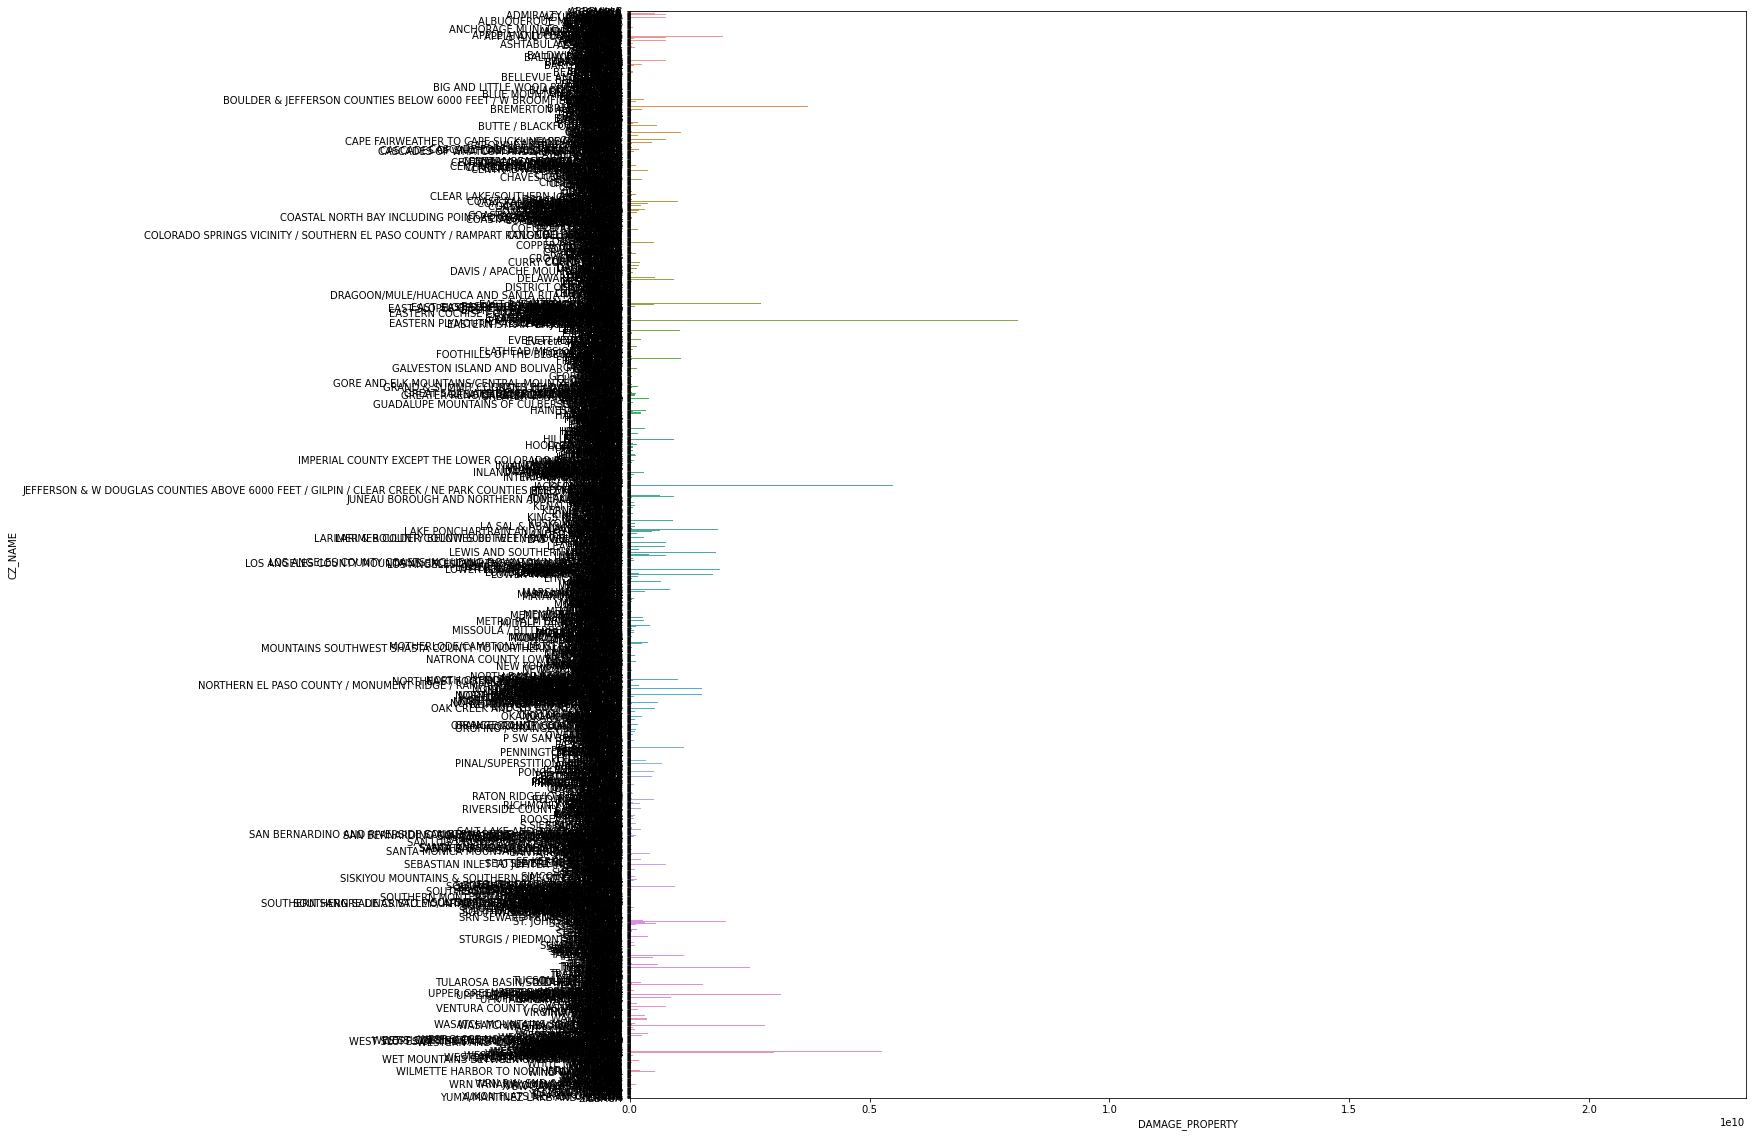

In [140]:
plt.figure(figsize=(20, 20))

df14 = df_train[['CZ_NAME','DAMAGE_PROPERTY']]
df144 = df14.groupby('CZ_NAME').sum().reset_index()
df1444 = df144[df144.DAMAGE_PROPERTY > 1000000]
g = sns.barplot(data= df1444, y='CZ_NAME', x='DAMAGE_PROPERTY',ci=None)
plt.show()

In [69]:
print(df_train.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum() > 100000)
print(df_train.groupby('STATE')['DAMAGE_PROPERTY'].sum() > 100000)

EVENT_TYPE
Astronomical Low Tide         False
Avalanche                      True
Blizzard                       True
Coastal Flood                  True
Cold/Wind Chill                True
Debris Flow                    True
Dense Fog                      True
Dense Smoke                    True
Drought                        True
Dust Devil                     True
Dust Storm                     True
Excessive Heat                 True
Extreme Cold/Wind Chill        True
Flash Flood                    True
Flood                          True
Freezing Fog                   True
Frost/Freeze                   True
Funnel Cloud                  False
Hail                           True
Heat                           True
Heavy Rain                     True
Heavy Snow                     True
High Surf                      True
High Wind                      True
Hurricane                      True
Hurricane (Typhoon)            True
Ice Storm                      True
Lake-Effect Snow 

<AxesSubplot:xlabel='YEAR'>

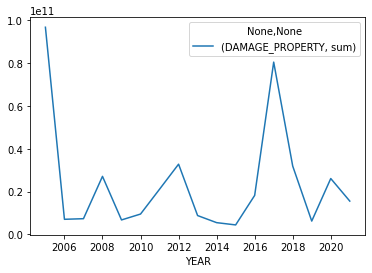

In [49]:

df1 = df_train11.groupby('YEAR').agg({'DAMAGE_PROPERTY' : ['sum']})
df1.plot()


<AxesSubplot:xlabel='YEAR'>

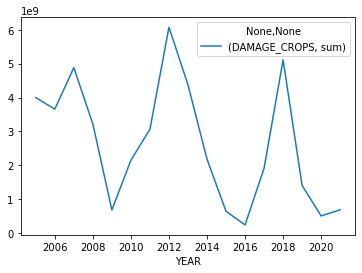

In [50]:
df2 = df_train11.groupby('YEAR').agg({'DAMAGE_CROPS' : ['sum']})
df2.plot()

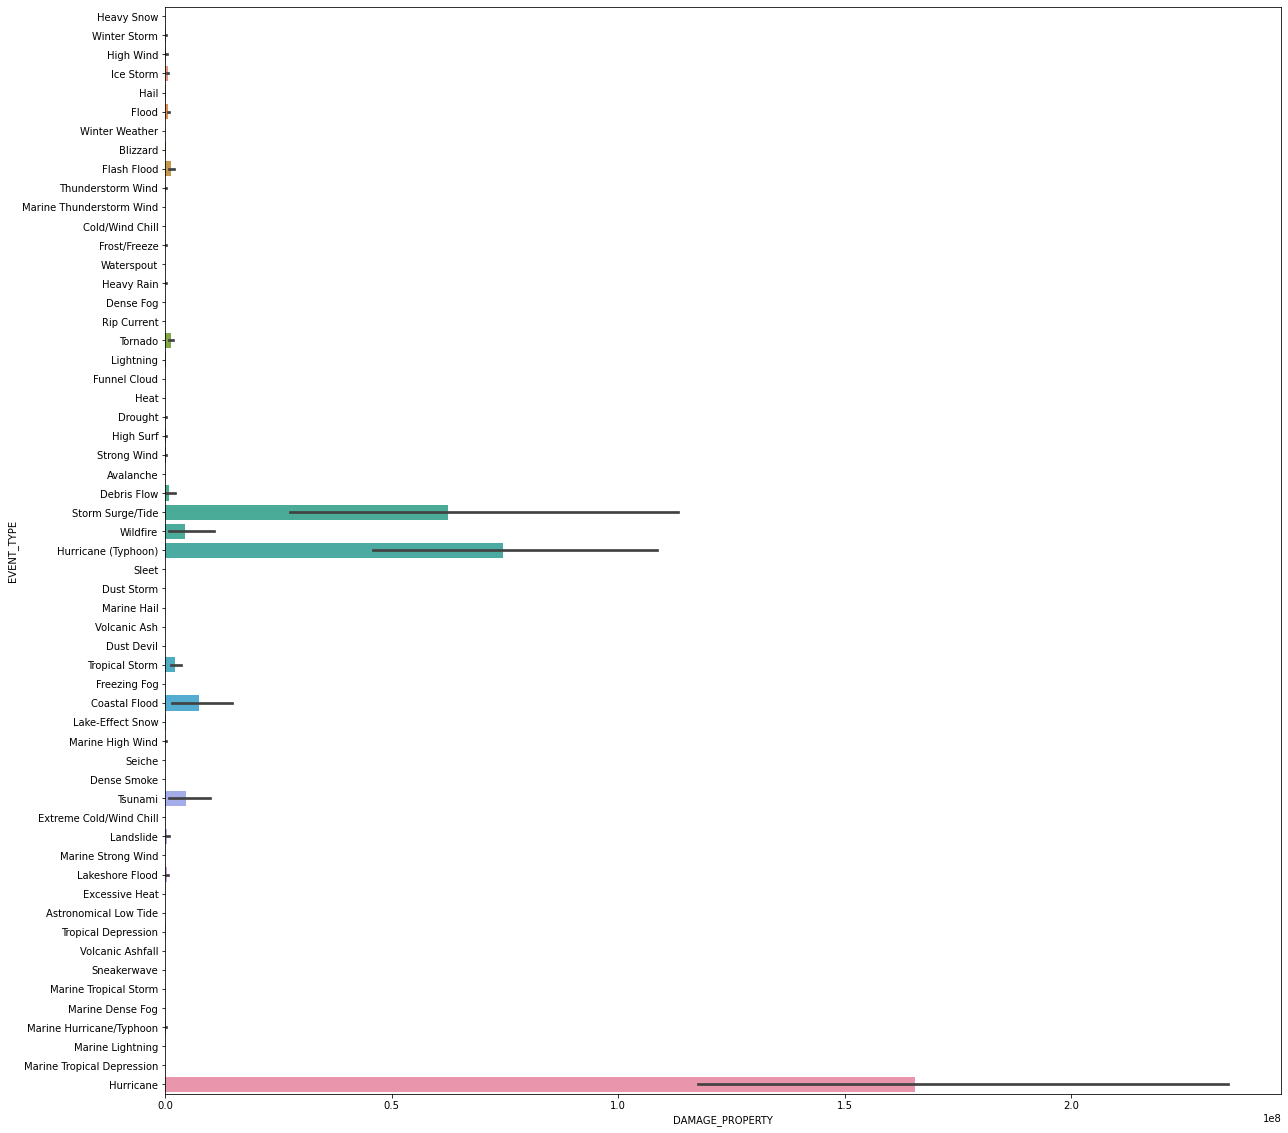

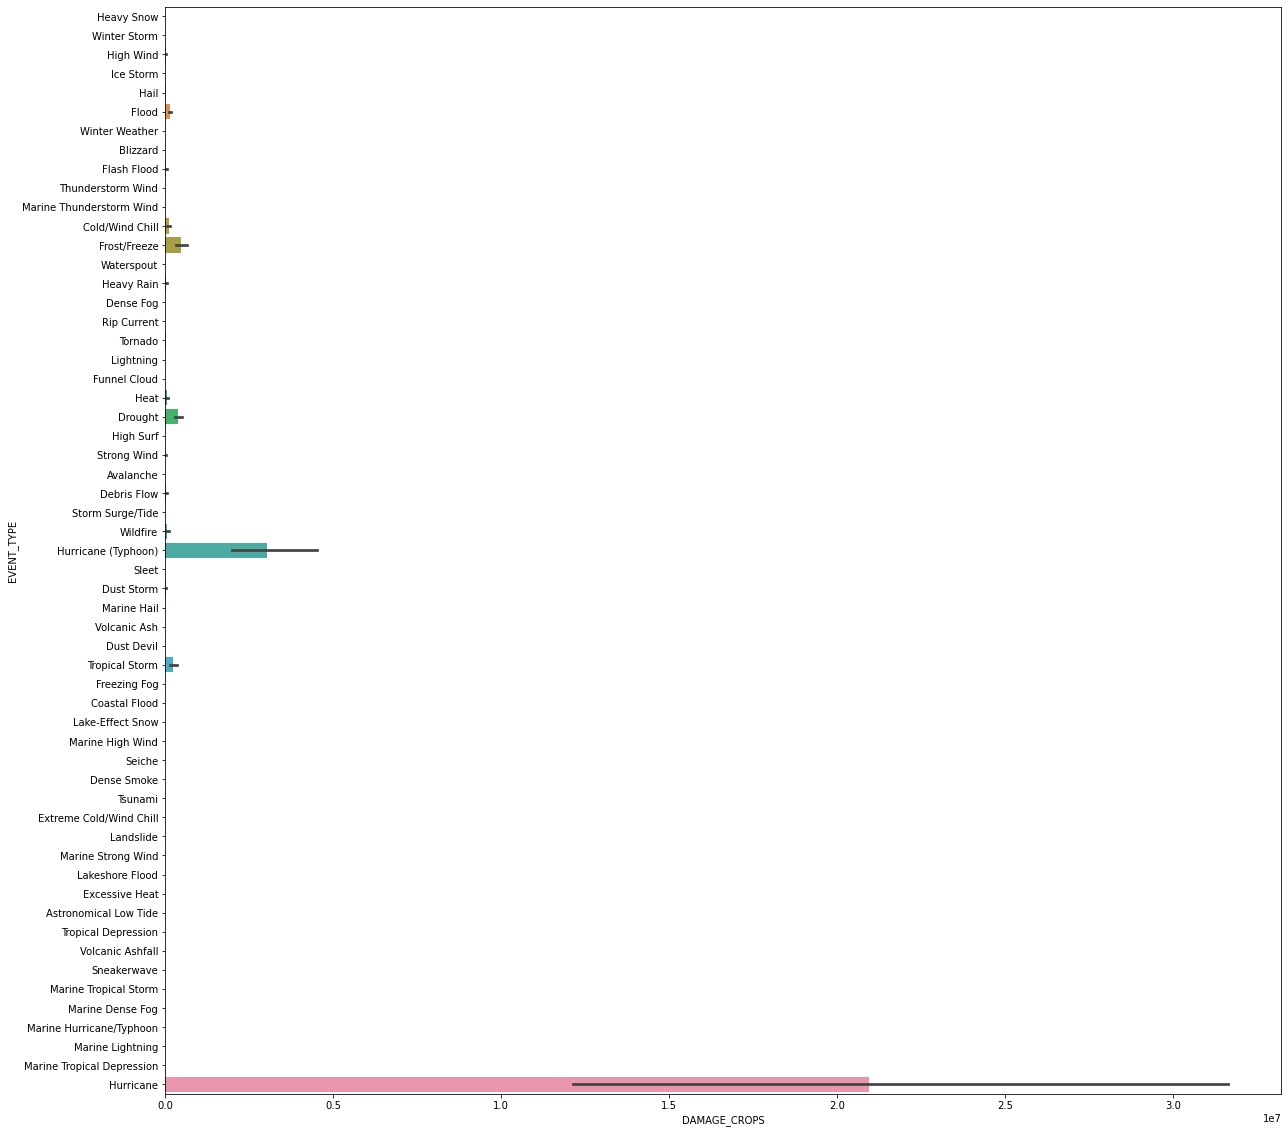

In [53]:
plt.figure(figsize=(20, 20))
sns.barplot(data=df_train11, y='EVENT_TYPE', x='DAMAGE_PROPERTY')
plt.show()

plt.figure(figsize=(20, 20))
sns.barplot(data=df_train11, y='EVENT_TYPE', x='DAMAGE_CROPS')
plt.show()

In [ ]:
# sns.distplot(df_train['DAMAGE_PROPERTY'])
# plt.show()

df_train['HasDamage'] = pd.Series(len(df_train['DAMAGE_PROPERTY']), index=df_train.index)
df_train['HasDamage'] = 0 
df_train.loc[df_train['DAMAGE_PROPERTY']>0,'HasDamage'] = 1

df_train.loc[df_train['HasDamage']==1,'DAMAGE_PROPERTY'] = np.log(df_train['DAMAGE_PROPERTY'])

df_train.drop(columns=['HasDamage'], inplace=True)

df_train.info()

In [ ]:
def mapping(xx):
    dict = {}
    count = -1
    for x in xx:
        dict[x] = count + 1
        count = count + 1
    return dict

# ['STATE', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE','TOR_F_SCALE', 'TOR_OTHER_WFO','TOR_OTHER_CZ_STATE', 'STATE_FIPS', 'WFO', 'SOURCE', 'CATEGORY', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'DATA_SOURCE']
for i in ['STATE', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'MAGNITUDE_TYPE', 'STATE_FIPS', 'WFO', 'SOURCE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'DATA_SOURCE']:
    unique_tag = df_train[i].value_counts().keys().values
    dict_mapping = mapping(unique_tag)
    df_train[i] = df_train[i].map(lambda x: dict_mapping[x] if x in dict_mapping.keys() else -1)


In [ ]:
corrmat = df_train.corr()

print(corrmat)

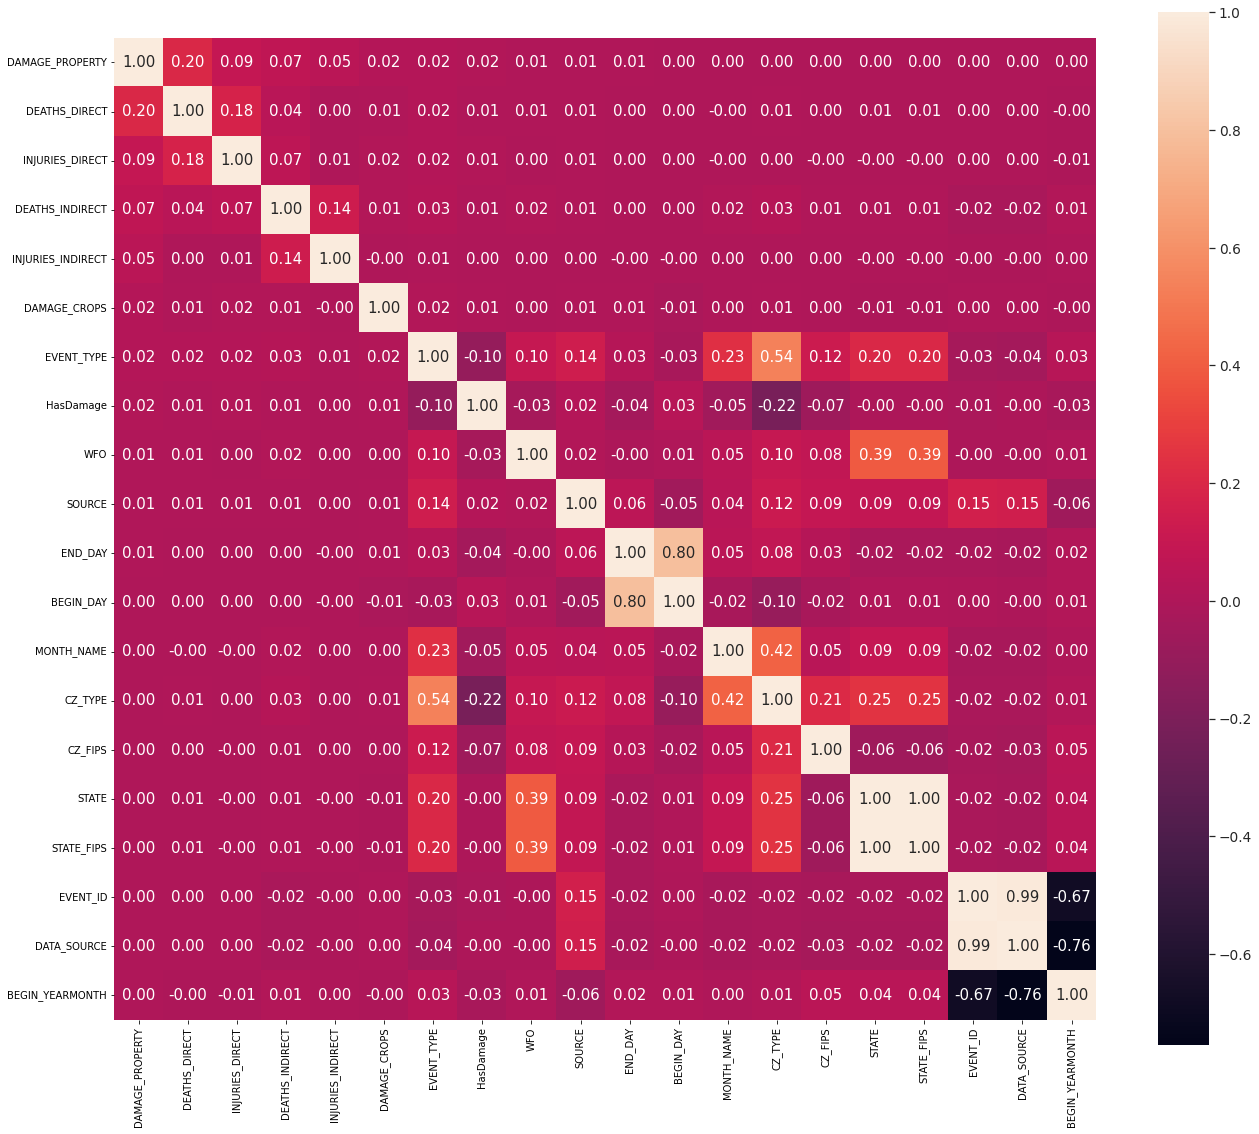

In [ ]:
f, ax = plt.subplots(figsize=(22, 19))
# sns.heatmap(corrmat, vmax=1.0, square=True)
# plt.show()

#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'DAMAGE_PROPERTY')['DAMAGE_PROPERTY'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
X = df_train.loc[:, ~df_train.columns.isin(['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'CZ_NAME', 'BEGIN_DATE_TIME','CZ_TIMEZONE', 'END_DATE_TIME', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_LOCATION', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON'])]

#X = df_train.loc[:, df_train.columns.isin(['DEATHS_DIRECT', 'DEATHS_INDIRECT', 'INJURIES_DIRECT', 'DAMAGE_CROPS'])]
Y = df_train['DAMAGE_PROPERTY']
# Y = df_train['DAMAGE_CROPS']

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)


# sc = StandardScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)

       BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  ...  WIND_SPEED  HAIL_SIZE  HasDamage
43726           200110         13         200  ...        50.0        0.0          0
34347           200506          5        1920  ...        56.0        0.0          0
25189           201012         15        1254  ...         0.0        0.0          0
34570           200207          2        1325  ...        50.0        0.0          0
36710           201201         17         920  ...        56.0        0.0          1
...                ...        ...         ...  ...         ...        ...        ...
7736            200501         21        1000  ...         0.0        0.0          0
16740           200205         17        1545  ...         0.0        0.0          1
35076           201504         17        2045  ...         0.0        0.0          0
5579            200501         22        1500  ...         0.0        0.0          0
42144           201907         19        1202  ...        55.0   

In [ ]:
# pca = PCA(.95)
# pca.fit(X_train)


# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# print(X_train.shape)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

print(model)

# make predictions for test data
y_pred = model.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(model.score(X_train,y_train))

print(r2_score(y_test, y_pred))


LinearRegression()
596784861914940.4
0.0509917817959914
0.04216441379739555


In [69]:
clf_rf = RandomForestRegressor(max_depth=10, random_state=0)

# perform training
clf_rf.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_rf.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(clf_rf.score(X_train,y_train))

print(r2_score(y_test, y_pred))

KeyboardInterrupt: ignored

In [ ]:
# rfc = XGBRegressor()

# parameters = {
#     'max_depth': range(2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# xgb = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy')


xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# print(xgb.feature_importances_)

# make predictions for test data
y_pred = xgb.predict(X_test)
y_pred_score = [round(value) for value in y_pred]

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

print(xgb.score(X_train,y_train))

print(r2_score(y_test, y_pred))

In [ ]:
print(xgb.score(y_test, y_pred))

In [ ]:
clf_dt = DecisionTreeRegressor()

# perform training
clf_dt.fit(X_train, y_train)

# make predictions

# prediction on test using all features
y_pred = clf_dt.predict(X_test)

MSE = mean_squared_error(y_pred,y_test)
print(MSE)

# print(1 - (1-clf_dt.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))


print(clf_dt.score(X_train,y_train))

In [ ]:
alpha_range = 10.**np.arange(-2, 3)

ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error')
ridgeregcv.fit(X_train, y_train)
ridgeregcv.alpha_

y_pred = ridgeregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))

In [ ]:
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoregcv.fit(X_train, y_train)
print('alpha : ',lassoregcv.alpha_)

y_pred = lassoregcv.predict(X_test)

print("R-Square Value",r2_score(y_test,y_pred))